In [1]:
import numpy as np
import gpkit
from gpkit import Model, Variable
from gpkit.constraints.bounded import Bounded
import matplotlib.pyplot as plt

​

In [2]:
#define a module describing the water
class Material():
    def __init__(self, name, rho, sigma_yield, sigma_ultimate):
        self.name = name
        self.rho  = rho
        self.sigma_yield = sigma_yield
        self.sigma_ultimate = sigma_ultimate
        
    def __str__(self):
        string = f"Material: {self.name}"
        
        return string


class Water(Model):
    def setup(self):
        rho = Variable("\\rho", 1000, "kg/m^3", "Water density")
        m   = self.m = Variable("m", "g", "Mass of water")
        V   = self.V = Variable("V", "L", "Volume of water")
        
        V_min = 0.35*gpkit.ureg.L
        
        return [m == rho*V, V >= V_min]
    
class GeneralTank(Model):
    def setup(self, P, material):
        
        #assumes the P is the maximum operating pressure 
        constraints = []
        
        
        #design
        r = self.r = Variable("r", "cm", "Tank Radius")
        t = self.t = Variable("t", "mm", "Tank Thickness")
        l = self.l = Variable("l", "cm", "Tank Length")
        
        self.V_internal = np.pi*r**2*l
        constraints += [r <= 5*gpkit.ureg.cm]
        constraints += [l <= 10*gpkit.ureg.cm]
        constraints += [r >= 10*t] #ensures thin wall approx can be used. 
        
        #pressures
        FOSY = Variable("FOSY", 1.0, "", "Factor of Safety: Yield")
        FOSU = Variable("FOSU", 1.0, "", "Factor of Safety: Ultimate")
        jb   = Variable("j_{burst}", 1.5, "", "burst factor")
        jp   = Variable("j_{proof}", 1.25, "", "proof factor")
        
        P_burst = self.P_burst = Variable("P_{burst}", "bar", "burst pressure")
        P_proof = self.P_proof = Variable("P_{proof}", "bar", "proof pressure")
        
        
        constraints += [P_burst >= jb*(1+FOSU)*P]
        constraints += [P_proof >= jp*(1+FOSY)*P]
        
        #stresses
        sigma_vm_p = self.sigma_vm_p = Variable("\\sigma_{vm, proof}", "MPa", "Proof Von misses stress in tank")
        sigma_vm_b = self.sigma_vm_b = Variable("\\sigma_{vm, burst}", "MPa", "Burst Von misses stress in tank")
        
        constraints += [sigma_vm_p == (np.sqrt(3)/2)*P_proof*r/t]
        constraints += [sigma_vm_b == (np.sqrt(3)/2)*P_burst*r/t]
        
        constraints += [sigma_vm_p <= material.sigma_yield]
        constraints += [sigma_vm_b <= material.sigma_ultimate]
        
        #mass
        m = self.m = Variable("m", "g", "Mass of tank")
        
        rho = self.rho = material.rho
        
        #mass calculator
        constraints += [m >= rho*(2*np.pi*r*t*l + 2*np.pi*r**2*t)]
        
        return constraints

    
class EllipsoidTank(Model):
    def setup(self, P, material):
        
        #assumes the P is the maximum operating pressure 
        constraints = []
        
        #assumptions
        ew = Variable("ew", 1, "", "Weld efficiency")
        
        #stresses
        sigma_vm_p = self.sigma_vm_p = Variable("\\sigma_{vm, proof}", "MPa", "Proof Von Misses stress in tank")
        sigma_vm_b = self.sigma_vm_b = Variable("\\sigma_{vm, burst}", "MPa", "Burst Von Misses stress in tank")
        sigma_vm   = self.sigma_vm   = Variable("\\sigma_{vm, max}", "MPa", "Maximum allowed Von Misses stress in tank")
        
        #calc max allowed von misses stress in tank
        constraints += [sigma_vm_p == material.sigma_yield]
        constraints += [sigma_vm_b == material.sigma_ultimate]
        constraints += [sigma_vm <= sigma_vm_p/10, sigma_vm <= sigma_vm_b/10]
        
        
        #design
        l = self.l = Variable("l", "cm", "Tank Cylinder Length")
        a = self.a = Variable("a", "cm", "Tank Cylinder Radius")
        k = self.k = Variable("k", "", "Tank Shape Factor")
        b = self.b = Variable("b", "cm", "Tank Ellipsoid depth")
        te  = self.te  = Variable("t_e", "mm", "Tank Ellipsoid Thickness")
        tc  = self.tc  = Variable("t_c", "mm", "Tank Cylinder Thickness")
        tcr = self.tcr = Variable("t_cr", "mm", "Tank Crown Thickness")
        tk  = self.tk  = Variable("t_k", "mm", "Tank Knucle Thickness")
        maxl= self.maxl= Variable("L_max", 87, "mm", "Maximum dimension in any direction")
        
        constraints += [k>=1, k<=2, k == a/b, a >= 10*tc, k*a>= 10*te] #definitions and limits
        constraints += [l + 2*b <= maxl] #geometric constraints on this problem
        constraints += [a <= maxl/2]
        
        #geometric factors
        #Ep = Variable("Ep", "", "Surface Area parameter")
        #constraints += [Ep >= 2.75826 + 1.0838*k + 0.150079*k**2, Ep <= 2.75826 + 1.0838*k + 0.150079*k**2]
        Ep = 2.75826 + 1.0838*k + 0.150079*k**2
        #K  = Variable("K", "", "Envelope Stress parameter")
        #constraints += [K == 0.52*k + 0.16]
        K = 0.52*k + 0.16
        
        #thicknesses
        constraints += [tcr >= P*k*a/(2*sigma_vm*ew)]
        constraints += [tk  >= K*P*a/(sigma_vm*ew)]
        constraints += [te  >= (tcr+tk)/2]
        constraints += [tc  >= P*a/(sigma_vm*ew)]
        
        
        #determine interal volume
        #V_internal = self.V_internal = Variable("V_{internal}", "cm^3", "Tank Internal Volume")
        V_internal = self.V_internal = 4*np.pi*a**3/(3*k) + np.pi*a**2*l
        
        #determine tank mass
        m = self.m = Variable("m", "g", "Mass of tank")
        rho = self.rho = material.rho
        constraints += [m >= rho*(np.pi*a**2*te*Ep/k + 2*np.pi*a*l*tc)]
        
        return constraints
    
    def computeVinternal(self, a, k, l):
        #assumes it is either a variable, or a consistent set of units
        return 4*np.pi*a**3/(3*k) + 2*np.pi*a**2*l



class MainTank(Model):
    def setup(self):
        
        #define operation condition
        P_expected = self.P_expected = Variable("P_{expected}", 4, "bar", "Maximum expected pressure")
        T = self.T = Variable("T", 300, "K", "Temperature of Main Tank")
        
        rho_al = Variable("\\rho_{Al}", 2.7,"g/cm^3","Al tank density")
        sigma_yield = Variable("\\sigma_{y, al}", 276, "MPa", "Al yield strength")
        sigma_ultimate = Variable("\\sigma_{u, al}", 310, "MPa", "Al ultimate strength")
        al = Material('Al', rho=rho_al, sigma_yield=sigma_yield, sigma_ultimate = sigma_ultimate)
        #define tank material
        self.material = al
        
        #create tank
        tank = self.tank = EllipsoidTank(P_expected, material = self.material)
        V_H2O  = self.V_H2O   = Variable("V_{H2O Tank}", "cm^3", "Volume of Water Tank")
        
        #create water
        water = Water()
        #assemble components
        components = self.components = [water, tank]
        
        constraints = []        
        constraints += components
        
        #require water to fit in tank
        constraints += [water.V <= V_H2O]
        constraints += [V_H2O <= tank.V_internal]
        
        #determine total mass
        m = self.m = Variable("m", "g", "Main Tank Mass")
        
        constraints += [m >= sum(comp.m for comp in components)]
        
        return constraints
    
    
class Helium(Model):
    def setup(self, P, V, m, T):
        #describes the ideal gas law of helium
        constraints = []
        #gas constants
        R = 8.31446261815324*(gpkit.ureg.J/gpkit.ureg.K)/gpkit.ureg.mol
        M = 4.002602*gpkit.ureg.g/gpkit.ureg.mol

        self.m = m
        constraints += [P*V == m*R*T/M]

        return constraints
    
class HeliumTank(Model):
    def setup(self):
        
        constraints = []
        components = self.components = []
        
        #create tank
        P_He_i = self.P_He_i = Variable("P_{He, initial}", "bar", "Initial maximum expected pressure of Helium Tank")
        V_He   = self.V_He   = Variable("V_{He, Tank}", "cm^3", "Volume of Helium Tank")
        
        rho_al = Variable("\\rho_{Al}", 2.7,"g/cm^3","Al tank density")
        sigma_yield = Variable("\\sigma_{y, al}", 276, "MPa", "Al yield strength")
        sigma_ultimate = Variable("\\sigma_{u, al}", 310, "MPa", "Al ultimate strength")
        al = Material('Al', rho=rho_al, sigma_yield=sigma_yield, sigma_ultimate = sigma_ultimate)
        
        tank = self.tank = EllipsoidTank(P_He_i, material = al)
        components += [tank]
        
        constraints += [tank.V_internal >= V_He]
        
        #create helium
        m_He = self.m_He = Variable("m_{He}", "g", "Mass of Helium")
        T = self.T = Variable("T", "K", "Helium Temperature")
        
        #constraints += [m_He >= 1*gpkit.ureg.g] #define minimum mass of Helium
        constraints += [T >= 100*gpkit.ureg.K, T <= 400*gpkit.ureg.K]
        
        He_initial = Helium(P = P_He_i, V = V_He, m = m_He, T = T)
        
        self.He_initial = He_initial

        components += [He_initial]
        
        #determine total mass
        m = self.m = Variable("m", "g", "He Tank Mass")
        
        constraints += [m >= sum(comp.m for comp in components)]
        
        constraints += components
        
        return constraints
        
        

In [3]:
class TankSystem(Model):
    def setup(self):
        
        constraints = []
        
        mainTank = self.mainTank = MainTank()
        heliumTank = self.heliumTank = HeliumTank()
        
        components = self.components = [mainTank, heliumTank]
        constraints += [components]
        
        #create final helium, but dont include in mass breakdown
        He_final = Helium(P = mainTank.P_expected, V = mainTank.V_H2O, m = heliumTank.m_He, T = mainTank.T)
        
        constraints += [He_final]
        #constraints += [He_initial.m >= 1*gpkit.ureg.g]

        
        m = self.m = Variable("m", "g", "mass of full tank system")
        constraints += [m >= sum(comp.m for comp in components)]
        
        return constraints

In [4]:
with gpkit.SignomialsEnabled():
    ts=TankSystem()
    
problem = Model(ts.m, ts)

print(problem.localsolve(verbosity=2,iteration_limit = 30).table())

Beginning signomial solve.
Using solver 'cvxopt'
Solving for 34 variables.
Solving took 0.0624 seconds.
Using solver 'cvxopt'
Solving for 34 variables.
Solving took 0.0571 seconds.
Using solver 'cvxopt'
Solving for 34 variables.
Solving took 0.0601 seconds.
Using solver 'cvxopt'
Solving for 34 variables.
Solving took 0.0698 seconds.
Using solver 'cvxopt'
Solving for 34 variables.
Solving took 0.0576 seconds.
Using solver 'cvxopt'
Solving for 34 variables.
Solving took 0.0574 seconds.
Using solver 'cvxopt'
Solving for 34 variables.
Solving took 0.0734 seconds.
Using solver 'cvxopt'
Solving for 34 variables.
Solving took 0.087 seconds.
Using solver 'cvxopt'
Solving for 34 variables.
Solving took 0.0646 seconds.
Solving took 9 GP solves and 0.674 seconds.

Cost
----
 383.7 [g]

Free Variables
--------------
                   | TankSystem
                 m : 383.7   [g]   mass of full tank system

                   | TankSystem/HeliumTank
   P_{He, initial} : 9.302   [bar] Initial maxim

In [5]:
#this model includes the additional constraints that the wall thicknesses must be greater than some minimum

with gpkit.SignomialsEnabled():
    ts=TankSystem()
    
with gpkit.SignomialsEnabled():
    t_min = 0.2*gpkit.ureg.mm
    P_He_max = 20*gpkit.ureg.bar
    
    addConstraint = []
    addConstraint += [ts.heliumTank.tank.tcr>=t_min]
    addConstraint += [ts.heliumTank.tank.tk>=t_min]
    addConstraint += [ts.heliumTank.tank.tc>=t_min]
    addConstraint += [ts.heliumTank.tank.te>=t_min]
    
    addConstraint += [ts.mainTank.tank.tcr>=t_min]
    addConstraint += [ts.mainTank.tank.tk>=t_min]
    addConstraint += [ts.mainTank.tank.tc>=t_min]
    addConstraint += [ts.mainTank.tank.te>=t_min]
    addConstraint += [ts.heliumTank.P_He_i<=P_He_max]

    
problem = Model(ts.m, [ts, addConstraint])


In [6]:

print(problem.localsolve(verbosity=1,iteration_limit = 30).table())

Beginning signomial solve.
Solving took 9 GP solves and 0.811 seconds.

Cost
----
 383.7 [g]

Free Variables
--------------
                   | TankSystem.1
                 m : 383.7   [g]   mass of full tank system

                   | TankSystem.1/HeliumTank
   P_{He, initial} : 10.17   [bar] Initial maximum expected pressure of Helium Tank
                 T : 100     [K]   Helium Temperature
      V_{He, Tank} : 45.89   [cm³] Volume of Helium Tank
                 m : 8.51    [g]   He Tank Mass
            m_{He} : 0.2247  [g]   Mass of Helium

                   | TankSystem.1/HeliumTank/EllipsoidTank
\sigma_{vm, burst} : 310     [MPa] Burst Von Misses stress in tank
  \sigma_{vm, max} : 27.6    [MPa] Maximum allowed Von Misses stress in tank
\sigma_{vm, proof} : 276     [MPa] Proof Von Misses stress in tank
                 a : 2.065   [cm]  Tank Cylinder Radius
                 b : 2.065   [cm]  Tank Ellipsoid depth
                 k : 1             Tank Shape Factor
       

In [7]:
class SelfPressurantTank(Model):
    def setup(self):
        
        constraints = []
        
        #Define pressure
        P = Variable("P", 4, "bar", "Main Tank Pressure")
        
        #Define tank material
        rho_al = Variable("\\rho_{Al}", 2.7,"g/cm^3","Al tank density")
        sigma_yield = Variable("\\sigma_{y, al}", 276, "MPa", "Al yield strength")
        sigma_ultimate = Variable("\\sigma_{u, al}", 310, "MPa", "Al ultimate strength")
        al = Material('Al', rho=rho_al, sigma_yield=sigma_yield, sigma_ultimate = sigma_ultimate)
        
        
        rho_cu = Variable("\\rho_{Cu}", 8.96,"g/cm^3","Copper tank density")
        sigma_yield_cu = Variable("\\sigma_{y, cu}", 880, "MPa", "Al yield strength")
        sigma_ultimate_cu = Variable("\\sigma_{u, cu}", 950, "MPa", "Al ultimate strength")
        cu = Material('Cu', rho=rho_cu, sigma_yield=sigma_yield_cu, sigma_ultimate = sigma_ultimate_cu)

        rho_ti = Variable("\\rho_{Ti}", 4.43,"g/cm^3","Copper tank density")
        sigma_yield_ti = Variable("\\sigma_{y, Ti}", 70, "MPa", "Al yield strength")
        sigma_ultimate_ti = Variable("\\sigma_{u, Ti}", 220, "MPa", "Al ultimate strength")
        ti = Material('Ti', rho=rho_ti, sigma_yield=sigma_yield_ti, sigma_ultimate = sigma_ultimate_ti)
        #create tank
        tank = self.tank = EllipsoidTank(P,ti)
        
        #create water
        water = self.water = Water()
        
        components = self.components = [tank, water]
        constraints += [components]
        
        #create pressurant
        m_pressurant = Variable("m_pressurant", 1.25*2.74041, "g", "mass of pressurant, with 25% margin")
        V_pressurant = Variable("V_pressurant", 1.25*4.67465, "cm^3", "volume of pressurant as liquid, with 25% margin")
        
        constraints += [tank.V_internal >= V_pressurant + water.V]
        
        m = self.m = Variable("m", "g", "mass of full tank system")
        constraints += [m >= m_pressurant + sum(comp.m for comp in components)]
        
        return constraints

In [8]:
with gpkit.SignomialsEnabled():
    spt = SelfPressurantTank()
    
problem_spt = Model(spt.m, spt)

print(problem_spt.localsolve().table())

Beginning signomial solve.
Solving took 8 GP solves and 0.361 seconds.

Cost
----
 526.7 [g]

Free Variables
--------------
                   | SelfPressurantTank
                 m : 526.7   [g]   mass of full tank system

                   | SelfPressurantTank/EllipsoidTank
\sigma_{vm, burst} : 220     [MPa] Burst Von Misses stress in tank
  \sigma_{vm, max} : 7       [MPa] Maximum allowed Von Misses stress in tank
\sigma_{vm, proof} : 70      [MPa] Proof Von Misses stress in tank
                 a : 4.35    [cm]  Tank Cylinder Radius
                 b : 4.071   [cm]  Tank Ellipsoid depth
                 k : 1.068         Tank Shape Factor
                 l : 0.5577  [cm]  Tank Cylinder Length
                 m : 173.3   [g]   Mass of tank
               t_c : 2.486   [mm]  Tank Cylinder Thickness
              t_cr : 1.328   [mm]  Tank Crown Thickness
               t_e : 1.553   [mm]  Tank Ellipsoid Thickness
               t_k : 1.779   [mm]  Tank Knucle Thickness

        

In [9]:
#this model includes the additional constraints that the wall thicknesses must be greater than some minimum

with gpkit.SignomialsEnabled():
    t_min = Variable('t_min',1.0,'mm','Minimum Wall Thickness')
    
    addConstraint = []
    addConstraint += [spt.tank.tcr>=t_min]
    addConstraint += [spt.tank.tk>=t_min]
    addConstraint += [spt.tank.tc>=t_min]
    addConstraint += [spt.tank.te>=t_min]
    
    
problem_spt_con = Model(spt.m, [spt, addConstraint])

print(problem_spt_con.localsolve().table())

Beginning signomial solve.
Solving took 8 GP solves and 0.386 seconds.

Cost
----
 526.7 [g]

Free Variables
--------------
                   | SelfPressurantTank
                 m : 526.7   [g]   mass of full tank system

                   | SelfPressurantTank/EllipsoidTank
\sigma_{vm, burst} : 220     [MPa] Burst Von Misses stress in tank
  \sigma_{vm, max} : 7       [MPa] Maximum allowed Von Misses stress in tank
\sigma_{vm, proof} : 70      [MPa] Proof Von Misses stress in tank
                 a : 4.35    [cm]  Tank Cylinder Radius
                 b : 4.071   [cm]  Tank Ellipsoid depth
                 k : 1.068         Tank Shape Factor
                 l : 0.5577  [cm]  Tank Cylinder Length
                 m : 173.3   [g]   Mass of tank
               t_c : 2.486   [mm]  Tank Cylinder Thickness
              t_cr : 1.328   [mm]  Tank Crown Thickness
               t_e : 1.553   [mm]  Tank Ellipsoid Thickness
               t_k : 1.779   [mm]  Tank Knucle Thickness

        

In [10]:
spt.water

[gpkit.MonomialEquality(m_SelfPressurantTank/Water = V_SelfPressurantTank/Water*\rho_SelfPressurantTank/Water),
 gpkit.PosynomialInequality(V_SelfPressurantTank/Water >= 0.35)]

In [11]:
#this model includes the additional constraints that the wall thicknesses must be greater than some minimum

with gpkit.SignomialsEnabled():
    t_min = Variable('t_min',1,'mm','Minimum Wall Thickness')
    a_min = Variable('a_min',40,'mm','Minimum Tank Radius')
    mwater_min = Variable('m_water_min',380,'g','Minimum Tank Volume')
    
    addConstraint = []
    addConstraint += [spt.tank.tcr>=t_min]
    addConstraint += [spt.tank.tk>=t_min]
    addConstraint += [spt.tank.tc>=t_min]
    addConstraint += [spt.tank.te>=t_min]
    addConstraint += [spt.tank.a >=a_min]
    addConstraint += [spt.water.m >= mwater_min]
    
    
problem_spt_con = Model(spt.m, [spt, addConstraint])

print(problem_spt_con.localsolve().table())

Beginning signomial solve.
Solving took 4 GP solves and 0.167 seconds.

Cost
----
 611.7 [g]

Free Variables
--------------
                   | SelfPressurantTank
                 m : 611.7  [g]   mass of full tank system

                   | SelfPressurantTank/EllipsoidTank
\sigma_{vm, burst} : 220    [MPa] Burst Von Misses stress in tank
  \sigma_{vm, max} : 7      [MPa] Maximum allowed Von Misses stress in tank
\sigma_{vm, proof} : 70     [MPa] Proof Von Misses stress in tank
                 a : 4.35   [cm]  Tank Cylinder Radius
                 b : 3.314  [cm]  Tank Ellipsoid depth
                 k : 1.313        Tank Shape Factor
                 l : 2.072  [cm]  Tank Cylinder Length
                 m : 228.3  [g]   Mass of tank
               t_c : 2.486  [mm]  Tank Cylinder Thickness
              t_cr : 1.631  [mm]  Tank Crown Thickness
               t_e : 1.863  [mm]  Tank Ellipsoid Thickness
               t_k : 2.094  [mm]  Tank Knucle Thickness

                   | 

In [12]:
rho_al = Variable("\\rho_{Al}", 2.7,"g/cm^3","Al tank density")
sigma_yield_al = Variable("\\sigma_{y, al}", 276, "MPa", "Al yield strength")
sigma_ultimate_al = Variable("\\sigma_{u, al}", 310, "MPa", "Al ultimate strength")
al = Material('Al', rho=rho_al, sigma_yield=sigma_yield_al, sigma_ultimate = sigma_ultimate_al)
et = EllipsoidTank(Variable("P","bar"), al)

In [13]:
rho_cu = Variable("\\rho_{Cu}", 8.96,"g/cm^3","Copper tank density")
sigma_yield_cu = Variable("\\sigma_{y, cu}", 70, "MPa", "Al yield strength")
sigma_ultimate_cu = Variable("\\sigma_{u, cu}", 220, "MPa", "Al ultimate strength")
cu = Material('Cu', rho=rho_cu, sigma_yield=sigma_yield_cu, sigma_ultimate = sigma_ultimate_cu)
et = EllipsoidTank(Variable("P","bar"), cu)

In [14]:
et.computeVinternal(a=4.2, k = 2, l=1.811)

355.89243349667845

In [15]:
et.computeVinternal(a=3.042, k = 2, l=5.108)

355.952143913555

In [16]:
t_mins = np.logspace(-3, 0.5,20)
solutions=problem_spt_con.sweep({t_min: t_mins})

Solving over 20 passes.
Solving over 20 passes.
Sweeping took 5.2 seconds.


In [17]:
solutions['freevariables'];

/Users/Devansh/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


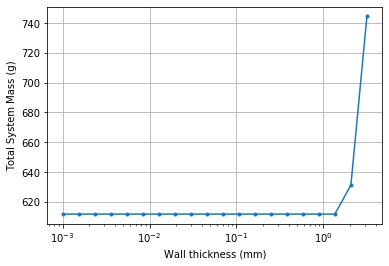

In [18]:
ax = plt.figure()
plt.semilogx(t_mins,solutions['cost'],'.-')
plt.grid()
plt.xlabel("Wall thickness (mm)")
plt.ylabel("Total System Mass (g)")
plt.show()